# LAB 1:  Exploring natality dataset.

**Learning Objectives**

1. Use BigQuery to explore natality dataset
1. Use Cloud AI Platform Notebooks plot explorations


## Introduction 
In this notebook, we will explore the natality dataset before we begin model development and training to predict the weight of a baby before it is born.  We will use BigQuery to explore the data and use Cloud AI Platform Notebooks to plot explorations.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/1_explore_babyweight.ipynb).

## Load necessary libraries

Check that the Google BigQuery library is installed and if not, install it. 

In [1]:
!pip freeze | grep google-cloud-bigquery==1.6.1 || pip install google-cloud-bigquery==1.6.1

google-cloud-bigquery==1.6.1


In [2]:
from google.cloud import bigquery

## The source dataset

Our dataset is hosted in [BigQuery](https://cloud.google.com/bigquery/). The CDC's Natality data has details on US births from 1969 to 2008 and is a publically available dataset, meaning anyone with a GCP account has access. Click [here](https://console.cloud.google.com/bigquery?project=bigquery-public-data&p=publicdata&d=samples&t=natality&page=table) to access the dataset.

The natality dataset is relatively large at almost 138 million rows and 31 columns, but simple to understand. `weight_pounds` is the target, the continuous value we’ll train a model to predict.

<h2> Explore data </h2>

The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that -- this way, twins born on the same day won't end up in different cuts of the data.

In [3]:
# Create SQL query using natality data after the year 2000
query = """
SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks,
    ABS(
        FARM_FINGERPRINT(
            CONCAT(
                CAST(YEAR AS STRING),
                CAST(month AS STRING)
            )
        )
    ) AS hashmonth
FROM
    publicdata.samples.natality
WHERE
    year > 2000
"""

In [4]:
# Call BigQuery and examine in dataframe
df = bigquery.Client().query(query + " LIMIT 100").to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.063611,True,32,1,37.0,7108882242435606404
1,4.687028,True,30,3,33.0,7170969733900686954
2,7.561856,True,20,1,39.0,6392072535155213407
3,7.561856,True,31,1,37.0,2126480030009879160
4,7.312733,True,32,1,40.0,3408502330831153141


Let's write a query to find the unique values for each of the columns and the count of those values.
This is important to ensure that we have enough examples of each data value, and to verify our hunch that the parameter has predictive value.

In [5]:
# Create function that gets distinct value statistics from BigQuery
def get_distinct_values(column_name):
    """Gets distinct value statstics of BigQuery data column.

    Args:
        column_name: str, name of column in BigQuery.
    Returns:
        Dataframe of unique values, their counts, and averages.
    """
    sql = """
    SELECT
        {0},
        COUNT(1) AS num_babies,
        AVG(weight_pounds) AS avg_wt
    FROM
        publicdata.samples.natality
    WHERE
        year > 2000
    GROUP BY
        {0}
    """.format(column_name)

    return bigquery.Client().query(sql).to_dataframe()

In [6]:
# Create function that plots distinct value statistics from BigQuery
def plot_distinct_values(column_name, logy=False):
    """Plots distinct value statstics of BigQuery data column.

    Args:
        column_name: str, name of column in BigQuery.
        logy: bool, if plotting counts in log scale or not.
    """
    df = get_distinct_values(column_name)
    df = df.sort_values(column_name)
    df.plot(x=column_name, y="num_babies", logy=logy, kind="bar")
    df.plot(x=column_name, y="avg_wt", kind="bar")

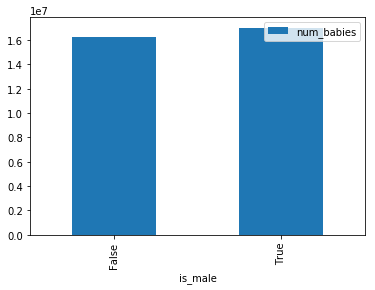

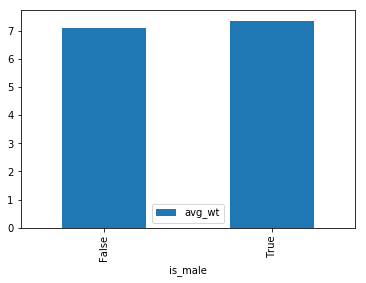

In [7]:
# Bar plot to see is_male with avg_wt linear and num_babies logarithmic
plot_distinct_values(column_name="is_male", logy=False)

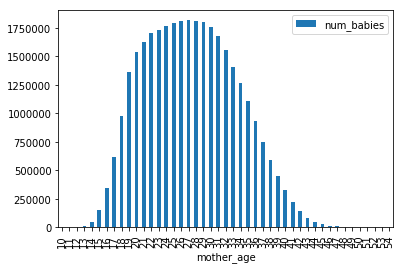

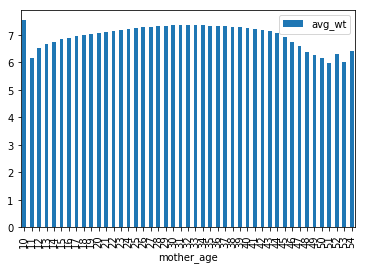

In [8]:
# Line plots to see mother_age with avg_wt linear and num_babies logarithmic
plot_distinct_values(column_name="mother_age", logy=False)

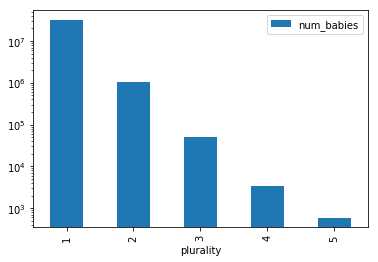

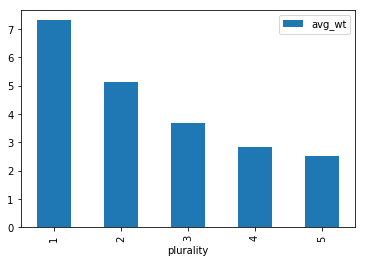

In [9]:
# Bar plot to see plurality with avg_wt linear and num_babies logarithmic
plot_distinct_values(column_name="plurality", logy=True)

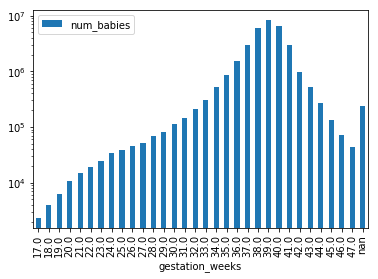

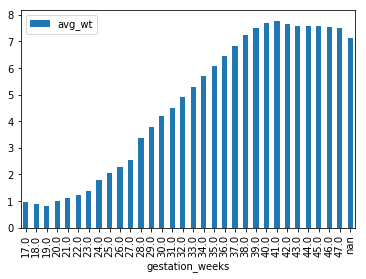

In [10]:
# Bar plot to see gestation_weeks with avg_wt linear and num_babies logarithmic
plot_distinct_values(column_name="gestation_weeks", logy=True)

All these factors seem to play a part in the baby's weight. Male babies are heavier on average than female babies. Teenaged and older moms tend to have lower-weight babies. Twins, triplets, etc. are lower weight than single births. Preemies weigh in lower as do babies born to single moms. In addition, it is important to check whether you have enough data (number of babies) for each input value. Otherwise, the model prediction against input values that doesn't have enough data may not be reliable.
<p>
In the next notebook, I will develop a machine learning model to combine all of these factors to come up with a prediction of a baby's weight.

## Lab Summary: 
In this lab we used BigQuery to explore the data and used Cloud AI Platform Notebooks to plot explorations.

Copyright 2017-2018 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License